This notebook introduces the Nickel-Strunz Version 10 classification to the GeoKB via a web scraping/tweaking exercise. We are working with blending minerals information from both Mindat and the Geoscience Ontology, which both provide identifiers for Strunz classification of minerals at the lowest level. To accommodate this and stay reasonably true to the developing ontology for the GeoKB, we need to introduce the higher level classification in some way. It is presented online in a web site, and not finding an alternative that had been encoded in some fashion for broader reference, this notebook works things through to the level of third level subclasses. Fourth and final subclasses will be introduced based on work done in the Geoscience Ontology.

To organize these items as classes, we introduced a top-level class as "Strunz-classified mineral material" in the GeoKB. We will still place mineral items under the general class of "mineral material," but the additional classification for minerals that have been classfied in the Strunz system will be queryable as such.

In [24]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from wbmaker import WikibaseConnection
import networkx as nx
import matplotlib.pyplot as plt



# Scrape Strunz-Nickel Classification

In [2]:
# Scrape main landing page
r = requests.get('http://webmineral.com/strunz.shtml')
soup = BeautifulSoup(r.text, 'html.parser')

data = []
for section in soup.find_all('dd'):
    subsections = section.find_all('dd')
    if subsections:
        class_content = section.find('b')
        class_link = class_content.find('a')
        strunz_class_label = class_link.text.strip()
        strunz_class_code = class_link['href'].split('=')[-1]
        data.append({
            'label': strunz_class_label,
            'code': strunz_class_code,
            'reference_url': f'http://webmineral.com/{class_link["href"]}',
            # 'subclasses': subclasses
        })

# Scrape class pages
subclasses = []
for c in data:
    r_class = requests.get(c['reference_url'])
    soup_class = BeautifulSoup(r_class.text, 'html.parser')
    c['description'] = soup_class.find_all('h2')[-1].text.split('-')[-1].strip()
    for tag in ['h3','h4']:
        for item in soup_class.find_all(tag):
            subclasses.append({
                'code': item.text.split('     ')[0].strip(),
                'label': item.text.split('     ')[-1].strip()
            })

# Prep records
df_strunz = pd.DataFrame(data + subclasses).sort_values('code').reset_index(drop=True)

def parent_code(code):
    if '.' not in code:
        return None
    else:
        if len(code) == 4:
            return code.split('.')[0]
        elif len(code) == 5:
            return code[:4]

def preferred_label(x):
    if x['parent_label'] is None:
        return x['label']

    if x['label'].startswith('With '):
        return f"{x['parent_label']} {x['label'].replace('With ', 'with ')}"
    elif x['label'].startswith('Unknown'):
        return f"Unknown {x['parent_label']}"
    elif x['label'].startswith('M:X'):
        return f"{x['parent_label']} - {x['label']}"
    elif x['label'].startswith('UO2:CO3'):
        return f"{x['parent_label']} - {x['label']}"
    else:
        return x['label']

df_strunz['parent_code'] = df_strunz['code'].apply(parent_code)
df_strunz = pd.merge(
    left=df_strunz,
    right=df_strunz[['code','label']].rename(columns={'code':'parent_code','label':'parent_label'}),
    how='left',
    on='parent_code'
)
df_strunz['preferred_label'] = df_strunz.apply(preferred_label, axis=1)

df_strunz = df_strunz[df_strunz['parent_label'].isnull() | df_strunz['parent_label'].str.len() > 0]
df_strunz = df_strunz[df_strunz['label'].str.len() > 0]
df_strunz = df_strunz[df_strunz['code'] != '09.']

# Commit to GeoKB
With an ordered table, we can work through it row by row, creating new items and then able to establish the appropriate subclass relationships. I had a little hiccup on duplicate labels that I had to correct.

In [25]:
geokb = WikibaseConnection('GEOKB_CLOUD')

In [4]:
df_strunz.head()

,label,code,reference_url,description,parent_code,parent_label,preferred_label
0,Elements,01,http://webmineral.com/strunz/strunz.php?class=01,ELEMENTS (Metals and intermetallic alloys; met...,None,NaN,Elements
1,Metals and Intermetallic Alloys,01.A,NaN,NaN,01,Elements,Metals and Intermetallic Alloys
2,Copper-cupalite family,01.AA,NaN,NaN,01.A,Metals and Intermetallic Alloys,Copper-cupalite family
3,Zinc-brass family (Cu-Zn alloys),01.AB,NaN,NaN,01.A,Metals and Intermetallic Alloys,Zinc-brass family (Cu-Zn alloys)
4,Indium-tin family,01.AC,NaN,NaN,01.A,Metals and Intermetallic Alloys,Indium-tin family


In [9]:
duplicated_labels = df_strunz[df_strunz['preferred_label'].duplicated(keep=False)]['preferred_label'].unique()

for label in duplicated_labels:
    rows = df_strunz[df_strunz['preferred_label'] == label]
    for _, row in rows.iterrows():
        df_strunz.loc[df_strunz['code'] == row['code'], 'preferred_label'] = f"{row['code']} {row['preferred_label']}"


In [15]:
q_strunz_items = """
PREFIX wdt: <https://geokb.wikibase.cloud/prop/direct/>

SELECT ?item ?itemLabel ?strunz_code
WHERE {
  ?item wdt:P168 ?strunz_code .
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en" . }
}
"""

strunz_items = geokb.sparql_query(q_strunz_items)
strunz_items['qid'] = strunz_items['item'].apply(lambda x: x.split('/')[-1])
code_qids = strunz_items.set_index('strunz_code')['qid'].to_dict()

In [16]:
strunz_class_ref = geokb.datatypes.Item(
    prop_nr=geokb.prop_lookup['knowledge source'],
    value='Q161391'
)

# code_qids = {}

for _, row in df_strunz[~df_strunz['code'].isin(code_qids.keys())].iterrows():
    item = geokb.wbi.item.new()
    item.labels.set('en', row['preferred_label'])
    if isinstance(row['description'], str):
        item.descriptions.set('en', row['description']) 
    else:
        item.descriptions.set('en', 'classification of minerals from the Strunz-Nickel classification system version 10')
    
    if isinstance(row['parent_code'], str):
        subclass_of = code_qids[row['parent_code']]
    else:
        subclass_of = 'Q161395'

    item.claims.add(
        geokb.datatypes.Item(
            prop_nr=geokb.prop_lookup['subclass of'],
            value=subclass_of,
            references=[strunz_class_ref]
        )
    )

    item.claims.add(
        geokb.datatypes.ExternalID(
            prop_nr=geokb.prop_lookup['Nickel-Strunz Version 10 Identifier'],
            value=row['code']
        )
    )

    if isinstance(row['reference_url'], str):
        item.claims.add(
            geokb.datatypes.URL(
                prop_nr=geokb.prop_lookup['reference URL'],
                value=row['reference_url']
            )
        )

    response = item.write(
        summary="Added Nickel-Strunz classification from webmineral.com"
    )

    code_qids[row['code']] = response.id

    print(f"Added {row['preferred_label']} - {response.id}")

Added 09.AB Nesosilicates without additional anions; - Q161743
Added 09.AC Nesosilicates without additional anions; - Q161744
Added 09.AD Nesosilicates without additional anions; - Q161745
Added Nesosilicates with additional  (O,OH,F,H2O); - Q161746
Added Nesosilicates with additional anions; - Q161747
Added Nesosilicates with additional anions; cations in > [6] ± [6] coordination - Q161748
Added Nesosilicates with CO3, SO4, PO4, etc. - Q161749
Added Nesosilicates with BO3 triangles and/or B[4], Be[4] tetrahedra, - Q161750
Added Uranyl neso- and polysilicates - Q161751
Added Garnet - Mn - Q161752
Added Sorosilicates - Q161753
Added 09.BB Si2O7 groups, without non-tetrahedral anions; - Q161754
Added 09.BC Si2O7 groups, without non-tetrahedral anions; - Q161755
Added 09.BD Si2O7 groups with additional anions; - Q161756
Added 09.BE Si2O7 groups with additional anions; - Q161757
Added 09.BF Sorosilicates with mixed SiO4 and Si2O7 groups; - Q161758
Added 09.BG Sorosilicates with mixed SiO4 

# Visualizing Classification
In the following codeblocks, I pull the classification graph between a given mineral item and the mineral material "root" item to help visualize the results of adding the Nickel-Strunz classification in the way that we did here as part of the core classification for the GeoKB. There are other ways of representing this in the knowledge graph that we might examine if this proves overly complicated.

In [14]:
q_albandite = """
PREFIX wdt: <https://geokb.wikibase.cloud/prop/direct/>
PREFIX wd: <https://geokb.wikibase.cloud/entity/>

SELECT ?item ?itemLabel ?subclass_of ?subclass_ofLabel
WHERE {
  wd:Q162191 wdt:P2* ?item .
  ?item wdt:P2* wd:Q24  .
  ?item wdt:P2 ?subclass_of .
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en" . }
}
"""

albandite_classification = geokb.sparql_query(q_albandite)
albandite_classification



,item,itemLabel,subclass_of,subclass_ofLabel
0,https://geokb.wikibase.cloud/entity/Q24,mineral material,https://geokb.wikibase.cloud/entity/Q19,natural material
1,https://geokb.wikibase.cloud/entity/Q24,mineral material,https://geokb.wikibase.cloud/entity/Q161224,solid geologic material
2,https://geokb.wikibase.cloud/entity/Q161395,Strunz-classified mineral material,https://geokb.wikibase.cloud/entity/Q24,mineral material
3,https://geokb.wikibase.cloud/entity/Q162191,Alabandite,https://geokb.wikibase.cloud/entity/Q24,mineral material
4,https://geokb.wikibase.cloud/entity/Q162191,Alabandite,https://geokb.wikibase.cloud/entity/Q161847,"02.CD.10 - Metal sulfide (M = S) with Sn, Pb, ..."
5,https://geokb.wikibase.cloud/entity/Q161419,Sulfides,https://geokb.wikibase.cloud/entity/Q161395,Strunz-classified mineral material
6,https://geokb.wikibase.cloud/entity/Q161430,"Metal Sulfides, M:S = 1:1 (and similar)",https://geokb.wikibase.cloud/entity/Q161419,Sulfides
7,https://geokb.wikibase.cloud/entity/Q161434,"Metal Sulfides, M:S = 1:1 (and similar) with S...",https://geokb.wikibase.cloud/entity/Q161430,"Metal Sulfides, M:S = 1:1 (and similar)"
8,https://geokb.wikibase.cloud/entity/Q161847,"02.CD.10 - Metal sulfide (M = S) with Sn, Pb, ...",https://geokb.wikibase.cloud/entity/Q161434,"Metal Sulfides, M:S = 1:1 (and similar) with S..."


In [15]:
G = nx.DiGraph()

for _, row in albandite_classification.iterrows():
    G.add_edge(row['itemLabel'], row['subclass_ofLabel'])

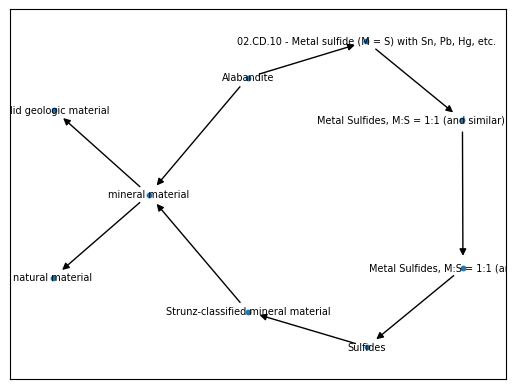

In [23]:
pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='sfdp')

nx.draw_networkx_nodes(G, pos, node_size=10)
nx.draw_networkx_edges(G, pos, arrows=True)
# nx.draw(G, pos, with_labels=False)
labels = nx.draw_networkx_labels(G, pos, font_size=7)

plt.show()